## Abstract

Simple Stellar Populations (SSPs) are the main ingredient in building reliable models
to extract the SFHs and CEHs of galaxies out of spectral fitting. We already have the
spectral fitting implementation (PIPE3D+FIT3D) and the MANGA datacubes to turn into
physical properties, but we are still missing that main ingredient. In this project
we will use the Stellar Population Synthesis code from BC03 to build SSP models.

In [1]:
import os, pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from astropy.io import fits
from astropy.coordinates import SkyCoord

import extinction
import dustmaps.sfd
dustmaps.sfd.fetch()

from dustmaps.sfd import SFDQuery
sfd = SFDQuery()

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, minmax_scale

from scipy.optimize import curve_fit
from scipy.ndimage import median_filter

sns.set(context="talk", style="ticks", palette="colorblind")

from MaStarChecks.constants import STELLAR_LIBRARIES_PATH, CACHE_PATH

from MaStarChecks.stellarLibraries.catalogues import build_indous_catalogue, build_miles_catalogue, build_mastar_catalogue
from MaStarChecks.stellarLibraries.spectra import load_indous_seds, load_miles_seds, load_mastar_seds

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [2]:
indous_reference, indous_catalogue, indous_parameter = build_indous_catalogue(use_cache=False)
miles_reference, miles_catalogue, miles_parameter = build_miles_catalogue(use_cache=False)
mastar_catalogue, mastar_parameter = build_mastar_catalogue(use_cache=False)

# build master catalogues
# miles_master = miles_catalogue.join(miles_parameter, how="inner")
# mastar_master = mastar_catalogue.join(mastar_parameter, how="inner")

building MILES catalogue: 100%|██████████| 706/706 [00:11<00:00, 59.42it/s] 


In [3]:
indous_seds = load_indous_seds(use_cache=False)
miles_seds = load_miles_seds(use_cache=False, ext_corrected=False)
mastar_quality, mastar_seds = load_mastar_seds(use_cache=False)

reading MILES SEDs: 100%|██████████| 985/985 [01:18<00:00, 12.56SED/s]


[MaStar SEDs] building from scratch
[MaStar SEDs] * quality flags


[MaStar SEDs] * library: 100%|██████████| 45670/45670 [00:31<00:00, 1436.22SED/s]


[MaStar SEDs] * cache
[MaStar SEDs] * done


In [4]:
print(miles_catalogue.sort_values("ra").head())
print(mastar_catalogue.sort_values("ra").head())

           HD          HR/BD          Sp.Type  [Ca/Fe]   CaT* errCaT* resCaT*  \
ID                                                                              
s0001  224930        HR 9088             G3 V     0.33  5.641   0.217  -0.215   
s0919     108    BD+ 62 2363  06 f pec      3      NaN  0.080   0.176     NaN   
s0124     249    BD+ 25 5073            K1 IV      NaN  7.059   0.236  -0.381   
s0582     417        HR 0019           K0 III      NaN  7.481   0.212   0.029   
s0012   1326B  BD+ 43 0044 B             M6 V      NaN  4.666   0.076  -1.186   

         CaT errCaT  resCaT    PaT  errPaT  resPaT  SN(A)          ra  \
ID                                                                      
s0001  6.000  0.234  -0.255  0.386   0.195  -0.043   73.2  00 02 10.2   
s0919 -0.958  0.192     NaN -1.117   0.152     NaN   95.4  00 06 03.4   
s0124  7.721  0.254  -0.429  0.712   0.212  -0.052   66.5  00 07 22.6   
s0582  8.206  0.227   0.014  0.780   0.191  -0.015   73.8  00 08 52

/home/mejia/.local/share/virtualenvs/mastar-checks-cT8c25tz/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/mejia/.local/share/virtualenvs/mastar-checks-cT8c25tz/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/mejia/.local/share/virtualenvs/mastar-checks-cT8c25tz/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/mejia/.local/share/virtualenvs/mastar-checks-cT8c25tz/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


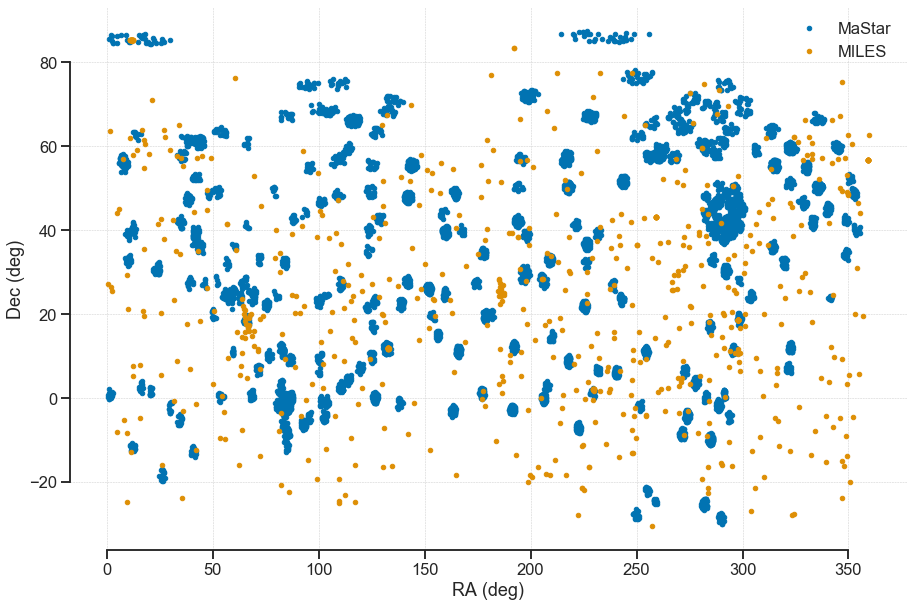

In [5]:
miles_coors = SkyCoord(miles_catalogue["ra"], miles_catalogue["dec"], unit=("hourangle", "deg"))
mastar_coors = SkyCoord(mastar_catalogue["ra"], mastar_catalogue["dec"], unit="deg")

plt.figure(figsize=(15,10))
plt.plot(mastar_coors.ra.value, mastar_coors.dec.value, ".", label="MaStar")
plt.plot(miles_coors.ra.value, miles_coors.dec.value, ".", label="MILES")
plt.legend(loc=0, frameon=False)
plt.xlabel(r"RA (deg)")
plt.ylabel(r"Dec (deg)")
plt.grid(lw=0.5, ls="--")
sns.despine(trim=True)

# idx, _, dist = miles_coors.match_to_catalog_3d(mastar_coors)

# plt.figure(figsize=(10,5))
# plt.hist(dist, histtype='step', hatch="///", range=(0, 1))
# plt.xlabel('Separation')
# plt.ylabel("Counts")
# sns.despine(trim=True)
# plt.tight_layout()

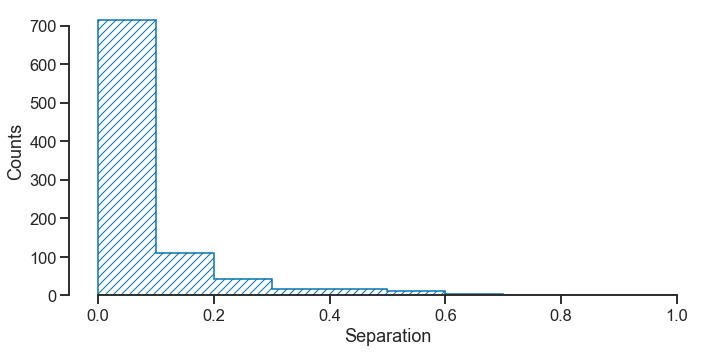

In [6]:
miles_parameter_ = miles_parameter.dropna(how="any", axis="index")
mastar_parameter_ = mastar_parameter.dropna(how="any", axis="index")

miles_coors = SkyCoord(x=miles_parameter_["[Fe/H]"], y=np.log10(miles_parameter_["Teff"]), z=miles_parameter_["logg"], representation_type="cartesian")
mastar_coors = SkyCoord(x=mastar_parameter_["[Fe/H]"], y=np.log10(mastar_parameter_["Teff"]), z=mastar_parameter_["logg"], representation_type="cartesian")

idx, _, dist = miles_coors.match_to_catalog_3d(mastar_coors)

plt.figure(figsize=(10,5))
plt.hist(dist, histtype='step', hatch="///", range=(0, 1))
plt.xlabel('Separation')
plt.ylabel("Counts")
sns.despine(trim=True)
plt.tight_layout()

In [7]:
print(miles_parameter_.head(5))
print(mastar_parameter_.iloc[idx, :].head(5))

matched_IDs = pd.DataFrame()
matched_IDs["MILES"] = miles_parameter_.index
matched_IDs["MaStar"] = mastar_parameter_.index[idx]

idx_sorted = np.argsort(dist)
matched_IDs = matched_IDs.loc[idx_sorted].reset_index(drop=True)
matched_IDs.head()

       [Fe/H]  Teff  logg
ID                       
s0001   -0.78  5411  4.19
s0002    0.14  4117  0.68
s0003   -0.51  5559  3.72
s0004    0.21  6779  3.87
s0005   -0.31  4731  2.83
                 logg         Teff    [Fe/H]  [alpha/M]
ID                                                     
3-158957632  4.261911  5058.225098 -0.807985   0.148153
7-20096109   0.635460  3486.300049  0.007858  -0.056201
3-48499962   3.691260  5741.195312 -0.509492   0.124299
3-110099828  3.819494  5290.031738  0.241892   0.077690
7-17396182   2.831359  4730.700195 -0.334160   0.074867


MILES       MaStar
0  s0801  3-142685112
1  s0810   7-17139014
2  s0418     7-737172
3  s0879   7-18619882
4  s0133   3-48498730

## Idea

We want to build the SSP models using the MaStar library. For that we have to take several steps:

* Check for the parameter space coverage in comparison with external libraries.
* Check for the spectra and its usefulness to derive stellar parameters:
  - wavelength/flux calibration
  - sky subtraction and other atmospheric effects
  - wavelength coverage and useful pixels
  again we will perform such checks using extrenal libraries.
* Extract stellar parameters: \[Fe/H\], Teff, log(g)
* Build Simple Stellar Population (SSP) models using BC/CB recipe
* Test the SSPs using known resolved stellar populations
* Integrate the new SSPs to PIPE3D

We have already started with the first two items from the list.

## Parameter space coverage

### Coverage

We compare the MaStar coverage with that of MILES (Sanchez-Blazquez+2006).
As of the current stellar parameter solutions for MaStar, we can see there
are not important differences with MILES.

/home/mejia/.local/share/virtualenvs/mastar-checks-cT8c25tz/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mejia/.local/share/virtualenvs/mastar-checks-cT8c25tz/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


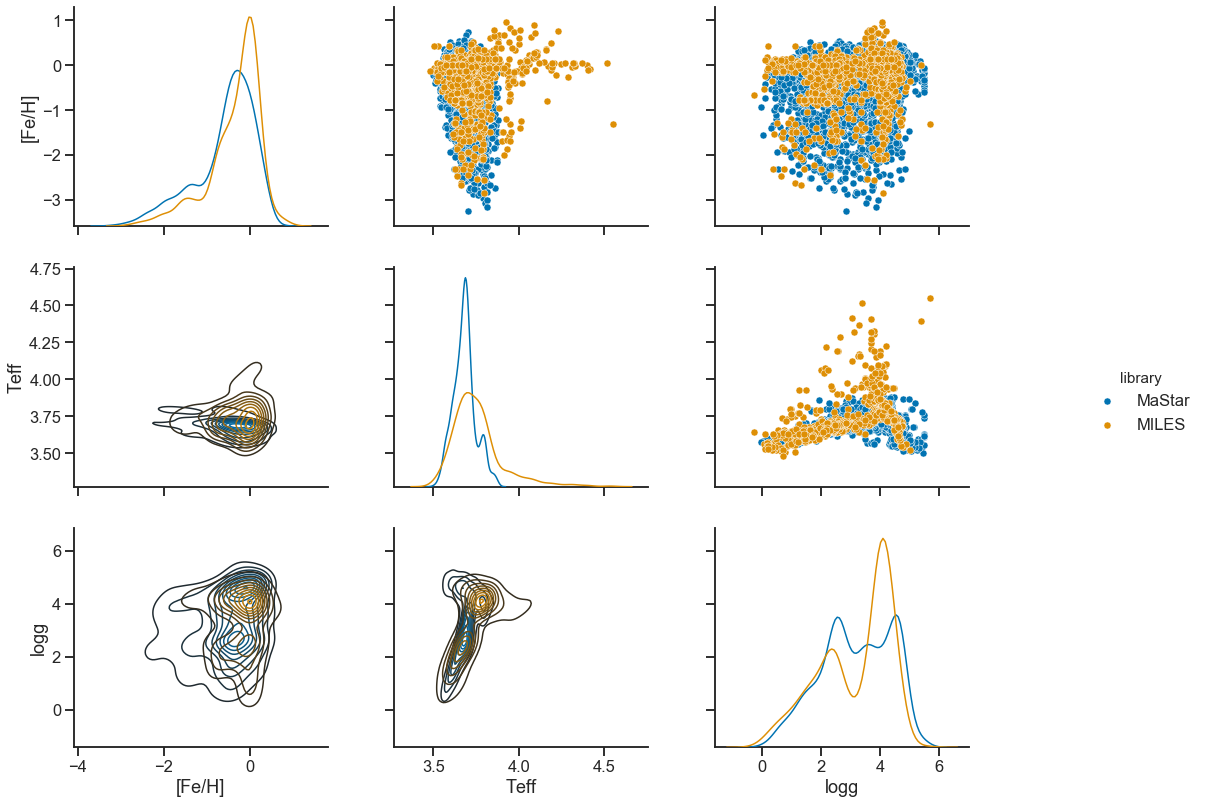

In [8]:
param_columns = ["[Fe/H]", "Teff", "logg"]
miles_parameter_["library"] = "MILES"
mastar_parameter_["library"] = "MaStar"

master_parameter = miles_parameter_.filter(items=param_columns+["library"]).append(mastar_parameter_.filter(items=param_columns+["library"]))
master_parameter["Teff"] = np.log10(master_parameter["Teff"])

miles_parameter_.drop(columns="library", inplace=True)
mastar_parameter_.drop(columns="library", inplace=True)

g = sns.PairGrid(master_parameter, hue="library", diag_sharey=False, hue_order=["MaStar", "MILES"])
g = g.map_lower(sns.kdeplot, linewidths=1.5)
g = g.map_upper(plt.scatter, lw=0.5, s=50, edgecolor="w")
g = g.map_diag(sns.kdeplot, lw=1.5)

g.add_legend()
g.fig.set_size_inches(18, 12)

sns.despine()
# plt.savefig("../_img/miles-mastar-comparison.png", bbox_inches="tight")

### Homogeinity

The homogeinity of each library in parameter space can give clues on how
(un)biased is the coverage of MaStar against previous libraries. To check
for homogeinity we use the K-means clustering algorithm and test for
structural parameters of the clusters found.

Estimated number of clusters: 3
Estimated number of noise points: 0
Silhouette Coefficient (-1, +1): 0.426
Calinski-Harabasz Index: 548.084
Davies-Bouldin Index: 0.875


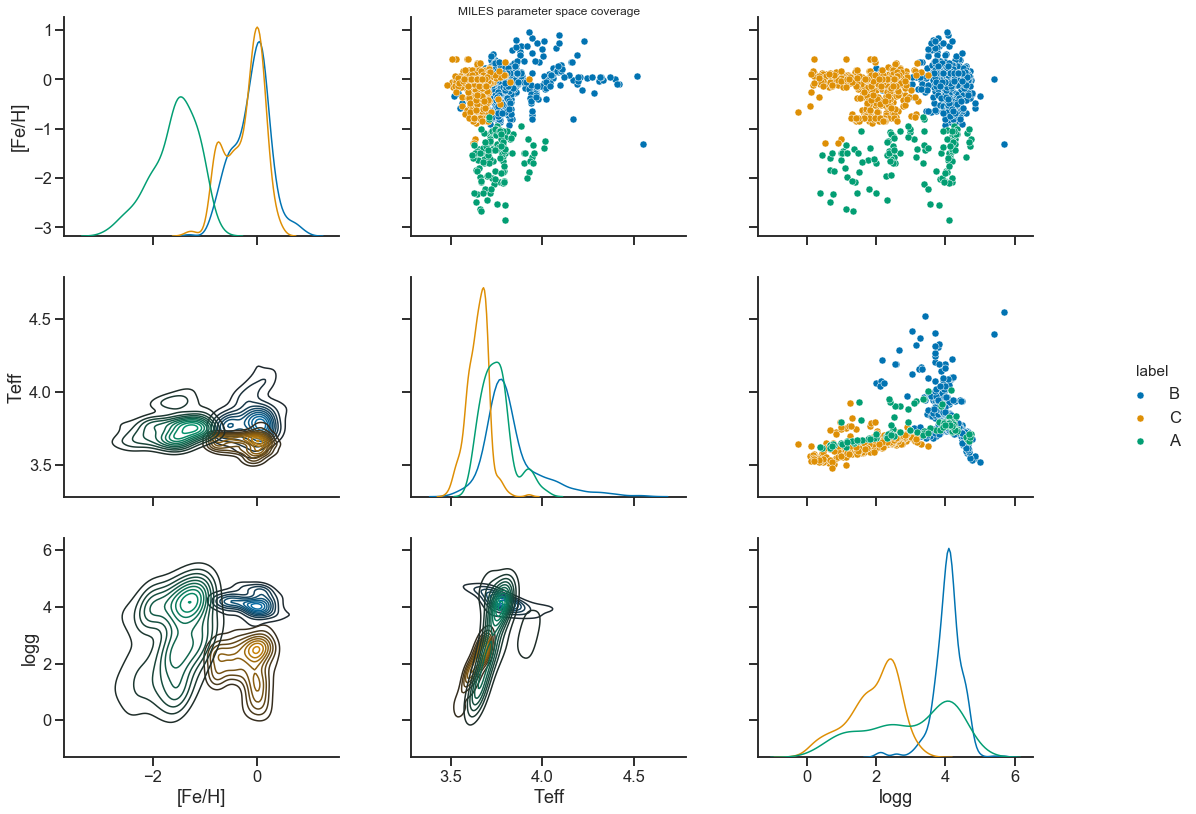

In [9]:
X = miles_parameter.filter(items=param_columns).copy()
X["Teff"] = np.log10(X["Teff"])
Xs = StandardScaler().fit_transform(X.values)

db = KMeans(n_clusters=3, random_state=145).fit(Xs)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient (-1, +1): %0.3f" % metrics.silhouette_score(Xs, labels))
print("Calinski-Harabasz Index: %0.3f" % metrics.calinski_harabasz_score(Xs, labels))
print("Davies-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(Xs, labels))

X["label"] = labels
X["label"].replace({0:"A", 1:"B", 2:"C", 3:"D"}, inplace=True)

g = sns.PairGrid(X, hue="label", diag_sharey=False)
g = g.map_lower(sns.kdeplot, linewidths=1.5)
g = g.map_upper(plt.scatter, lw=0.5, s=50, edgecolor="w")
g = g.map_diag(sns.kdeplot, lw=1.5)

g.add_legend()
g.fig.set_size_inches(18, 12)
plt.gcf().suptitle("MILES parameter space coverage")

sns.despine()
# plt.savefig("../_img/miles-coverage-comparison.png", bbox_inches="tight")

Estimated number of clusters: 3
Estimated number of noise points: 0
Silhouette Coefficient (-1, +1): 0.335
Calinski-Harabasz Index: 1323.122
Davies-Bouldin Index: 1.035


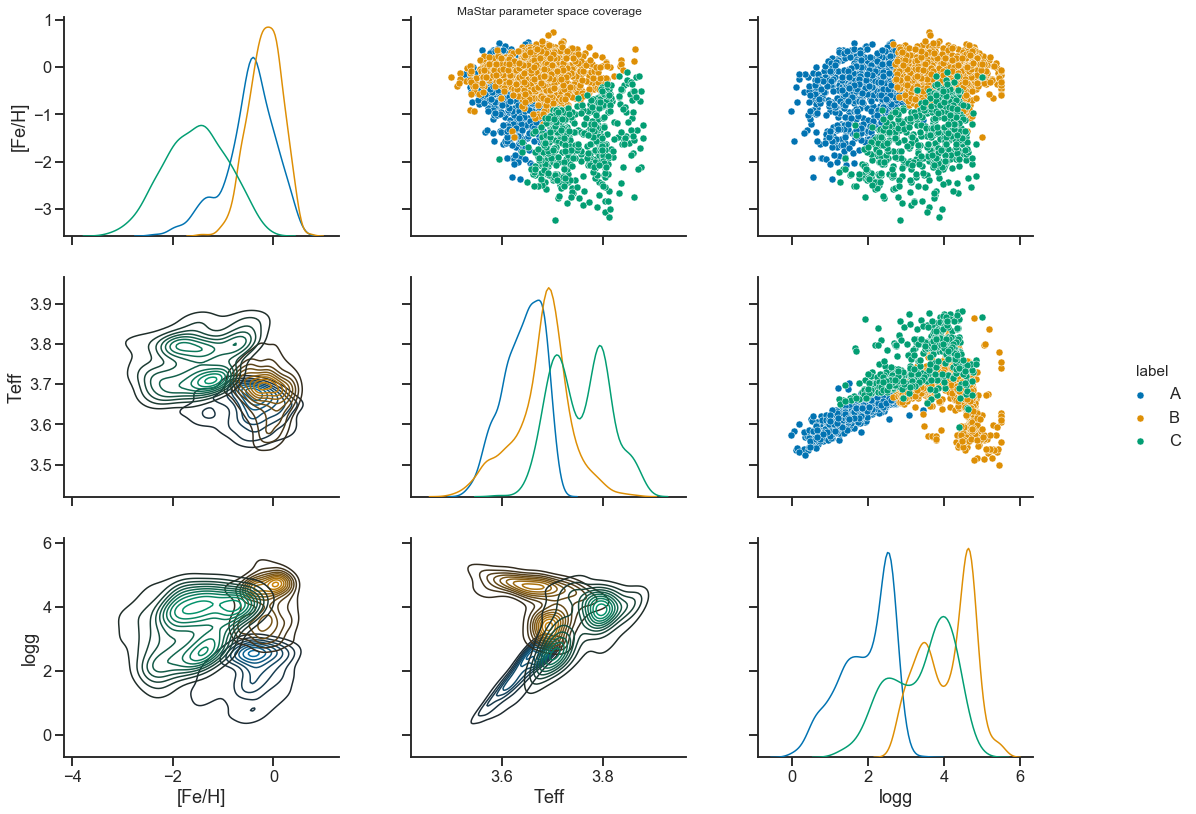

In [10]:
X = mastar_parameter_.filter(items=param_columns).copy()
X["Teff"] = np.log10(X["Teff"])
Xs = StandardScaler().fit_transform(X.values)

db = KMeans(n_clusters=3, random_state=145).fit(Xs)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient (-1, +1): %0.3f" % metrics.silhouette_score(Xs, labels))
print("Calinski-Harabasz Index: %0.3f" % metrics.calinski_harabasz_score(Xs, labels))
print("Davies-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(Xs, labels))

X["label"] = labels
X["label"].replace({0:"A", 1:"B", 2:"C", 3:"D"}, inplace=True)

g = sns.PairGrid(X, hue="label", diag_sharey=False)
g = g.map_lower(sns.kdeplot, linewidths=1.5)
g = g.map_upper(plt.scatter, lw=0.5, s=50, edgecolor="w")
g = g.map_diag(sns.kdeplot, lw=1.5)

g.add_legend()
g.fig.set_size_inches(18, 12)
plt.gcf().suptitle("MaStar parameter space coverage")

sns.despine()
# plt.savefig("../_img/mastar-coverage-comparison.png", bbox_inches="tight")

## Observables

In this section we test for the similarities between the stellar SEDs of
different libraries and see of there are sistematics due to some instrumental
and/or atomospheric effects.

### Clustering of SEDs

We first run a similarity tests on the observables using a distance metric for
sequential data sets called Dynamic Time Warping (DTW), originally designed for
time series. The idea is to cluster the libraries in the observables space and
see if these clusters are the same in other libraries. If the warping in wavelength
has systematics we can also check for wavelength/flux calibration errors.

### Direct comparison with MILES

Second, we look for systematics in the SED by comparing directly with stars in MILES
matching in parameter space.

/home/mejia/.local/share/virtualenvs/mastar-checks-cT8c25tz/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


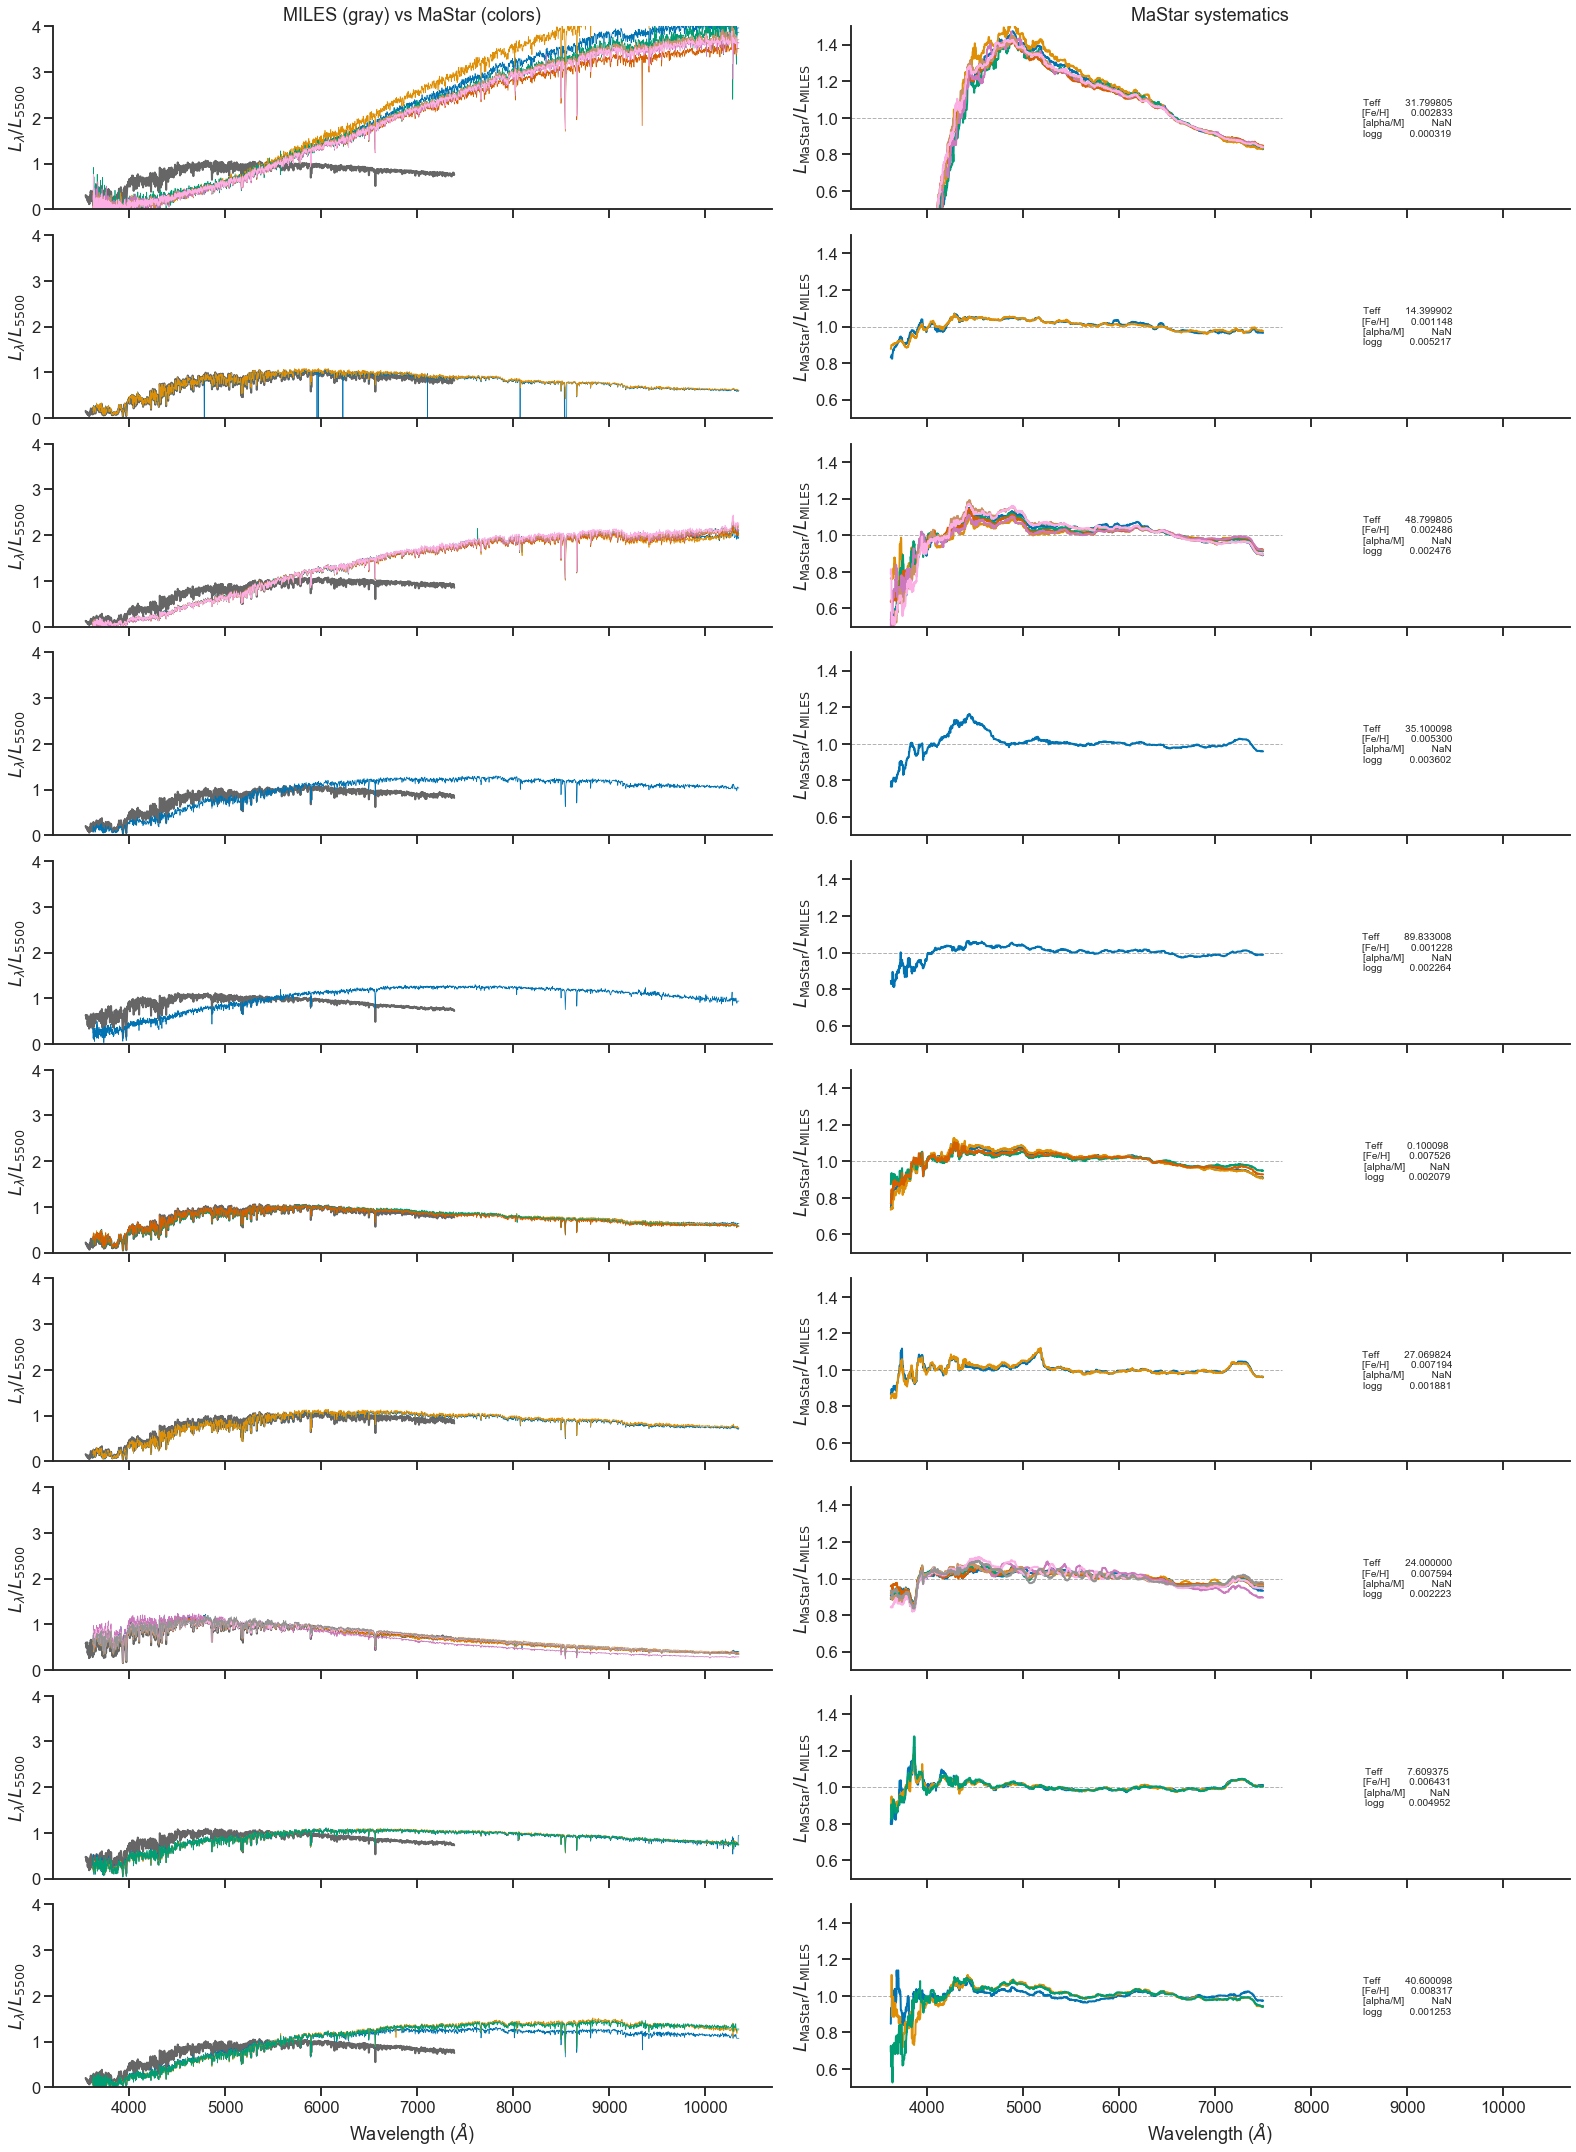

In [11]:
nsed = 10
npix = 50
Rv = 3.1
wl_normal = 5500

def model(x, *args):
    m, b = args
    return m*x+b

fig, axs = plt.subplots(nsed, 2, sharex=True, sharey="col", figsize=(22, 3*nsed))

for i, match in matched_IDs.head(nsed).iterrows():
    wl_miles, fl_miles = miles_seds.get(match.MILES, ([], []))
    iwl_normal = np.argmin(np.abs(wl_miles - wl_normal))
    fl_miles /= fl_miles[iwl_normal]
    
    axs[i, 0].plot(wl_miles[npix:-npix], fl_miles[npix:-npix], "-", color="0.4", lw=2)
    
    for mastar_sed in mastar_seds.get(match.MaStar, [([], [])]):
        wl_mastar, fl_mastar = mastar_sed["wl"], mastar_sed["fl"]
        iwl_normal = np.argmin(np.abs(wl_mastar - wl_normal))
        fl_mastar /= fl_mastar[iwl_normal]
        
        wl_mastar = wl_mastar / (1.0 + 2.735182E-4 + 131.4182 / wl_mastar**2 + 2.76249E8 / wl_mastar**4)
#         fl_mastar = extinction.remove(extinction.ccm89(wl_mastar, Rv * mastar_catalogue[~mastar_catalogue.index.duplicated()].loc[match.MaStar, "E(B-V)"], Rv), fl_mastar)
        
        
#         print(len(wl_mastar), len(wl_miles[npix:-npix]), len(fl_miles[npix:-npix]))
        fl_miles_res = np.interp(wl_mastar, wl_miles[npix:-npix], fl_miles[npix:-npix])
        mask = wl_mastar <= 7500
        
        params, _ = curve_fit(model, wl_mastar[mask], median_filter(fl_mastar[mask]/fl_miles_res[mask], size=50), p0=(1,0))
        axs[i, 0].plot(wl_mastar, fl_mastar, "-", lw=0.7)
        axs[i, 1].plot(wl_mastar[mask], median_filter(model(wl_mastar[mask], *params)/(fl_mastar[mask]/fl_miles_res[mask]), size=50), "-", lw=2)
    
    axs[i, 1].axhline(1.0, xmax=0.6, ls="--", color="0.7", lw=1, zorder=-999)
    
    if axs[i, 0].is_first_row():
        axs[i, 0].set_title("MILES (gray) vs MaStar (colors)")
        axs[i, 1].set_title("MaStar systematics")
    axs[i, 0].set_ylabel(r"$L_\lambda/L_{%d}$"%(wl_normal))
    axs[i, 1].set_ylabel(r"$L_{\rm MaStar}/L_{\rm MILES}$")
    axs[i, 0].set_ylim(0, 4)
    axs[i, 1].set_ylim(0.5, 1.5)
    if axs[i, 0].is_last_row():
        axs[i, 0].set_xlabel(r"Wavelength ($\AA$)")
        axs[i, 1].set_xlabel(r"Wavelength ($\AA$)")
        
    axs[i, 1].text(9000, 1, np.abs(miles_parameter.loc[match.MILES]-mastar_parameter.loc[match.MaStar]).to_string(), va="center", ha="center")

sns.despine(trim=False)
plt.tight_layout()
# plt.savefig("../_img/sed-comparison.png", bbox_inches="tight")